In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('build/lib.linux-x86_64-3.5')
%matplotlib inline
import beetracktracker
import pandas as pd

In [2]:
from test_beetracktracker import TestBeeTrackTracker
test=TestBeeTrackTracker()
 

In [3]:
mask,background = test.get_maskbackground()
blob, blob_center, blob_axes, blob_angle = test.get_randomblob(mask,background)
print(blob_center,blob_axes,blob_angle)

[763 683] [66 22] 7.05821857561


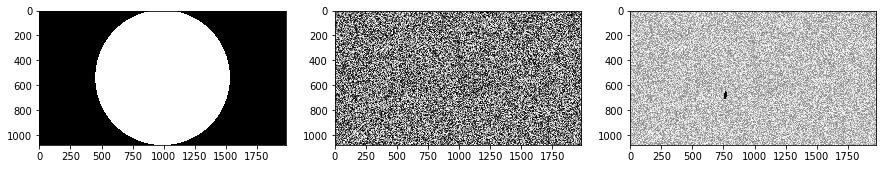

In [4]:
f,axarr=plt.subplots(1,3,figsize=(15,4))
for i, image in enumerate([mask,background,blob]):
    ax=axarr[i]
    ax.imshow(image,cmap=plt.get_cmap('gray'))

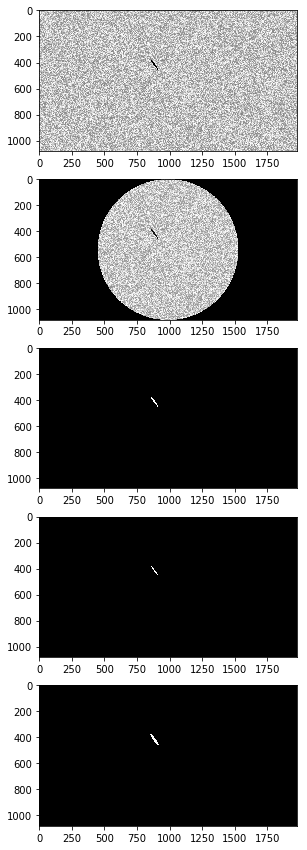

In [16]:
mybee=beetracktracker.beetracktracker()
mybee.set_mask(mask)
mybee.set_image(background)
mybee.set_area_lim(0,10000)
mybee.set_roundness_lim(0,1)
mybee.set_erode_iter(1)
mybee.set_dilate_iter(3)
mybee.set_roi(210,150)
mybee.set_max_nb_bee(4)
mybee.run()

max_error_pos=1 #px
max_angle_pos=1 #deg
max_simulated_blob=1

for _ in range(50):
    blob, blob_center, blob_axes, blob_angle = test.get_randomblob(mask,background)
    mybee.set_image(blob)
    mybee.run()
    
blobs=pd.DataFrame(index=np.arange(100),columns=['x','y','h','w','angle'],dtype=np.float)
detections=np.nan*blobs.copy()
for frame_i in blobs.index:
    blob, blob_center, blob_axes, blob_angle = test.get_randomblob(mask,background)
    blobs.loc[frame_i,['x','y']]=blob_center
    blobs.loc[frame_i,['h','w']]=blob_axes
    blobs.loc[frame_i,['angle']]=blob_angle
    
    mybee.set_image(blob)
    mybee.run()
    step=beetracktracker.beetracktracker.processing_steps.contours_filtered
    contours=mybee.get_data(step)
    detections.loc[frame_i,['x','y']]=contours[0,:2]
    detections.loc[frame_i,['h','w']]=contours[0,2:4]
    detections.loc[frame_i,['angle']]=contours[0,4]
    
    #if contours.shape[0]>max_simulated_blob:
    #    raise ValueError('Too many blobs detected')
    #elif contours.shape[0]<max_simulated_blob:
    #    raise ValueError('Too few blobs detected')
    
    px_error=np.sqrt(np.sum(contours[0,:2]-blob_center)**2)
    assert (px_error<max_error_pos), 'pixel error is too large {}>{}'.format(px_error,max_error_pos)
    angle_error=np.sqrt(np.sum(contours[0,4]-blob_angle)**2)
    #assert (angle_error<max_angle_pos), 'angle error is too large {}>{}'.format(angle_error,max_angle_pos)
    

f,axarr=plt.subplots(5,1,figsize=(15,15))
for i, step in enumerate([beetracktracker.beetracktracker.processing_steps.read,
                           beetracktracker.beetracktracker.processing_steps.masked,
                           beetracktracker.beetracktracker.processing_steps.segmented,
                           beetracktracker.beetracktracker.processing_steps.eroded,
                           beetracktracker.beetracktracker.processing_steps.dilated]):
    myim=mybee.get_data(step)
    ax=axarr[i]
    ax.imshow(myim,cmap=plt.get_cmap('gray'))

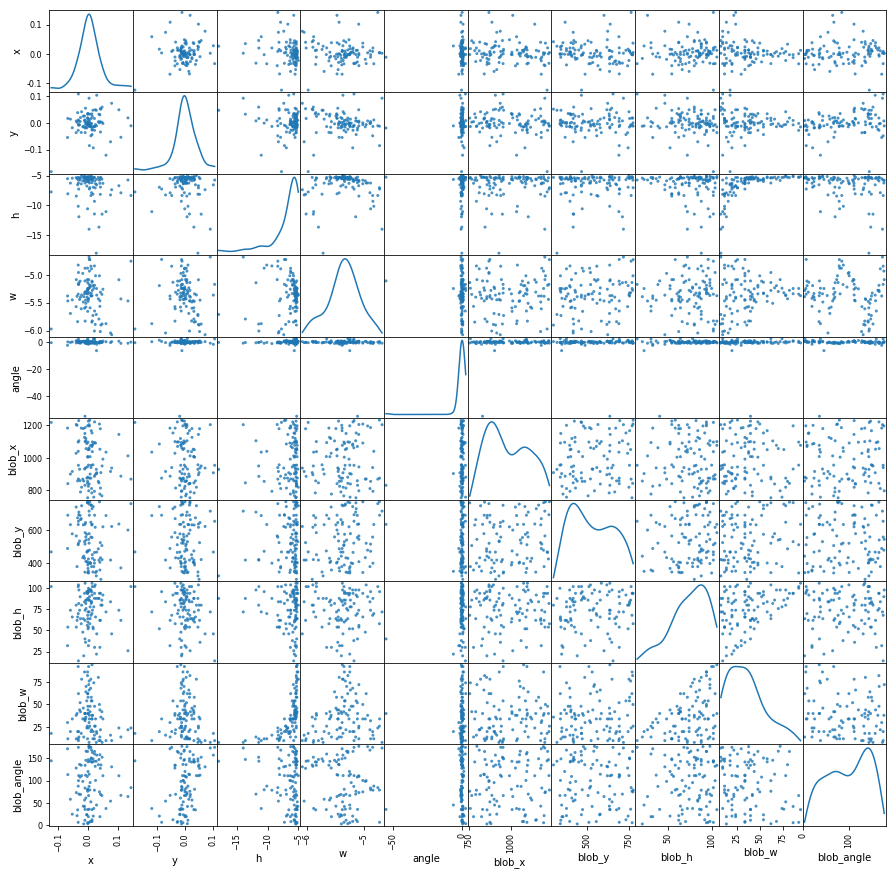

In [17]:
from pandas.plotting import scatter_matrix
df=blobs-detections
for col in blobs.columns:
    df['blob_'+col]=blobs.loc[:,col]
df=df.dropna()
scatter_matrix(df, alpha=0.8, figsize=(15, 15), diagonal='kde');

In [18]:
step=beetracktracker.beetracktracker.processing_steps.croped
croped=mybee.get_data(step)

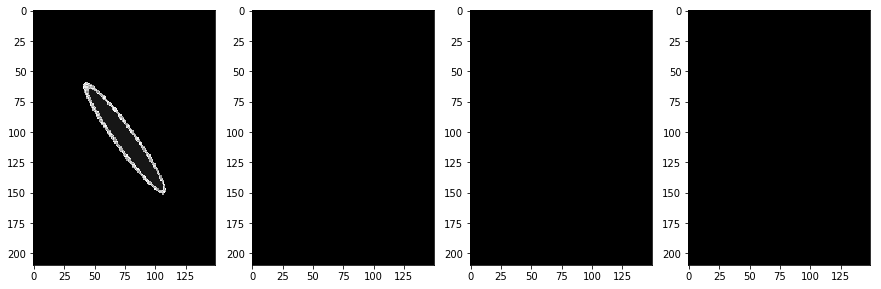

In [19]:
f,axarr=plt.subplots(1,4,figsize=(15,15))
for i in range(4):
    ax=axarr[i]
    ax.imshow(croped[i,:,:],cmap=plt.get_cmap('gray'))